# lingam.utils

In this example, we need to import `numpy`, `pandas`, and `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

We define utility functions to draw the directed acyclic graph.

In [2]:
def make_graph(adjacency_matrix, lower_limit=0.01):
    idx = np.abs(adjacency_matrix) > lower_limit
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(f'x{from_}', f'x{to}', label=f'{coef:.1f}')
    return d

In [3]:
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')
    
    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to], style='dashed')
    return d

## print_causal_directions

We create test data consisting of 6 variables.

In [4]:
x3 = np.random.uniform(size=10000)
x0 = 3.0*x3 + np.random.uniform(size=10000)
x2 = 6.0*x3 + np.random.uniform(size=10000)
x1 = 3.0*x0 + 2.0*x2 + np.random.uniform(size=10000)
x5 = 4.0*x0 + np.random.uniform(size=10000)
x4 = 8.0*x0 - 1.0*x2 + np.random.uniform(size=10000)
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])
X.head()

,x0,x1,x2,x3,x4,x5
0,2.394708,15.312359,3.685054,0.548814,15.780259,9.948090
1,2.325771,16.145216,4.332293,0.715189,14.335879,9.514409
2,2.197313,15.848718,4.539881,0.602763,14.027410,9.266158
3,1.672250,13.200354,3.675534,0.544883,10.421554,6.771233
4,1.282752,11.337503,3.486211,0.423655,7.533376,5.368668


We run booststrap and get the result.

In [5]:
model = lingam.DirectLiNGAM()
result = model.bootstrap(X, 100)

We can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method.

In [6]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01)

Then, we import `lingam.utils` and check the results with the `print_causal_directions` function.

In [7]:
from lingam.utils import print_causal_directions
print_causal_directions(cdc, 100)

x0 <--- x3  (100.0%)
x1 <--- x0  (100.0%)
x1 <--- x2  (100.0%)
x2 <--- x3  (100.0%)
x4 <--- x0  (100.0%)
x4 <--- x2  (100.0%)
x5 <--- x0  (100.0%)
x0 <--- x2  (15.0%)


We can also output by specifying the variable name.

In [8]:
labels = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
print_causal_directions(cdc, 100, labels=labels)

X1 <--- X4  (100.0%)
X2 <--- X1  (100.0%)
X2 <--- X3  (100.0%)
X3 <--- X4  (100.0%)
X5 <--- X1  (100.0%)
X5 <--- X3  (100.0%)
X6 <--- X1  (100.0%)
X1 <--- X3  (15.0%)


## print_dags

We use the bootstrap results above to get the ranking of the DAGs extracted.

In [9]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01)

Then, we import `lingam.utils` and check the results with the `print_dagc` function.

In [10]:
from lingam.utils import print_dagc
print_dagc(dagc, 100)

DAG[0]: 77.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x5 <--- x0 
DAG[1]: 14.0%
	x0 <--- x2 
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x5 <--- x0 
DAG[2]: 3.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x4 <--- x5 
	x5 <--- x0 


In [11]:
labels = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
print_dagc(dagc, 100, labels=labels)

DAG[0]: 77.0%
	X1 <--- X4 
	X2 <--- X1 
	X2 <--- X3 
	X3 <--- X4 
	X5 <--- X1 
	X5 <--- X3 
	X6 <--- X1 
DAG[1]: 14.0%
	X1 <--- X3 
	X1 <--- X4 
	X2 <--- X1 
	X2 <--- X3 
	X3 <--- X4 
	X5 <--- X1 
	X5 <--- X3 
	X6 <--- X1 
DAG[2]: 3.0%
	X1 <--- X4 
	X2 <--- X1 
	X2 <--- X3 
	X3 <--- X4 
	X5 <--- X1 
	X5 <--- X3 
	X5 <--- X6 
	X6 <--- X1 


## make_prior_knowledge
In order to perform causal discovery using prior knowledge of causal relations, `make_prior_knowledge` function that creates a prior knowledge matrix is provided. First, we import `lingam.utils` to use `make_prior_knowledge` function.

In [12]:
from lingam.utils import make_prior_knowledge

### Exogenous variables
If the exogenous variable is known, specify the variable index in the `exogenous_variables` argument.

In [13]:
pk = make_prior_knowledge(n_variables=3, exogenous_variables=[0, 1])
print(pk)

[[ 0  0  0]
 [ 0  0  0]
 [-1 -1  0]]


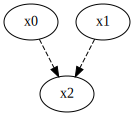

In [14]:
make_prior_knowledge_graph(pk)

### Sink variables
If the sink variable such as the target variable of the predictive model is already known, specify the variable index in the `sink_variables` argument.

In [15]:
pk = make_prior_knowledge(n_variables=3, sink_variables=[1, 2])
print(pk)

[[ 0  0  0]
 [-1  0  0]
 [-1  0  0]]


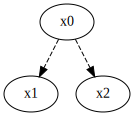

In [16]:
make_prior_knowledge_graph(pk)

### Directed path
If the causal direction between variables is already known, specify the variable index pair in the `paths` argument.

In [17]:
pk = make_prior_knowledge(n_variables=3, paths=[[0, 1]])
print(pk)

[[ 0  0 -1]
 [ 1  0 -1]
 [-1 -1  0]]


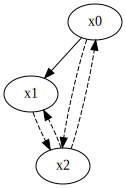

In [18]:
make_prior_knowledge_graph(pk)

### No directed path
If there is no causal direction between variables is already known, specify the variable index pair in the `no_paths` argument.

In [19]:
pk = make_prior_knowledge(n_variables=3, no_paths=[[0, 1]])
print(pk)

[[ 0 -1 -1]
 [ 0  0 -1]
 [-1 -1  0]]


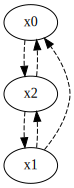

In [20]:
make_prior_knowledge_graph(pk)

### Mix all knowledge

All prior knowledge can be specified at the same time. A prior knowledge matrix is created with priorities in the order of `exogenous_variables`, `sink_variables`, `paths`, `no_paths`.

In [21]:
pk = make_prior_knowledge(
    n_variables=4,
    exogenous_variables=[3],
    sink_variables=[0],
    paths=[[1, 0]],
    no_paths=[[3, 0]],
)

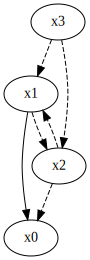

In [22]:
make_prior_knowledge_graph(pk)

## remove_effect
If it is considered that there are hidden common causes in X0(categorical variable) and X1 in following DAG, we want to run causal discovery excluding the effects of X0 and X1.

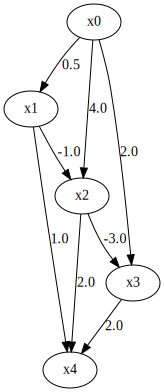

In [23]:
m = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.0, 0.0, 0.0],
              [4.0,-1.0, 0.0, 0.0, 0.0],
              [2.0, 0.0,-3.0, 0.0, 0.0],
              [0.0, 1.0, 2.0, 2.0, 0.0]])

make_graph(m)

In [24]:
# x0 = np.random.uniform(size=10000)
x0 = np.random.randint(2, size=10000)
x1 = 0.5*x0 + np.random.uniform(size=10000)
x2 = 4.0*x0 - 1.0*x1 + np.random.uniform(size=10000)
x3 = 2.0*x0 - 3.0*x2 + np.random.uniform(size=10000)
x4 = 1.0*x1 + 2.0*x2 + 2.0*x3 + np.random.uniform(size=10000)
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4'])
X.head()

,x0,x1,x2,x3,x4
0,0.0,0.050261,0.463783,-1.126735,-1.158823
1,1.0,1.178004,3.267241,-6.887056,-5.598983
2,1.0,0.540158,4.043353,-9.351763,-9.743842
3,1.0,1.349468,2.777060,-6.244626,-4.675765
4,1.0,0.794132,3.493286,-7.697956,-6.991642


In this cases, we can import `lingam.utils` and use `remove_effect` function.

In [25]:
from lingam.utils import remove_effect
remove_features=[0, 1]
X_removed = remove_effect(X, remove_features=remove_features)

If we run DirectLiNGAM on the dataset that excludes the effects of X0 and X1, we can get the following results:

[0, 2, 1, 3, 4]
[[ 0.     0.     0.     0.     0.   ]
 [ 0.493  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.    -2.998  0.     0.   ]
 [ 0.     0.     2.023  2.012  0.   ]]


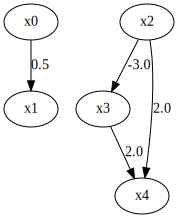

In [26]:
model = lingam.DirectLiNGAM()
model.fit(X_removed)
print(model.causal_order_)
print(model.adjacency_matrix_)
make_graph(model.adjacency_matrix_)

To add causal coefficients from variables whose effects have been removed, regression for each variable may be performed.

In [27]:
from sklearn import linear_model
from sklearn.utils import check_array

def get_reg_coef(X, features, target, gamma=1.0):
    X = np.copy(check_array(X))
    lr = linear_model.LinearRegression()
    lr.fit(X[:, features], X[:, target])
    weight = np.power(np.abs(lr.coef_), gamma)
    reg = linear_model.LassoLarsIC(criterion='bic')
    reg.fit(X[:, features] * weight, X[:, target])
    return reg.coef_ * weight

[[ 0.     0.     0.     0.     0.   ]
 [ 0.493  0.     0.     0.     0.   ]
 [ 3.987 -0.99   0.     0.     0.   ]
 [ 1.977  0.017 -2.998  0.     0.   ]
 [ 0.025  0.984  2.023  2.012  0.   ]]


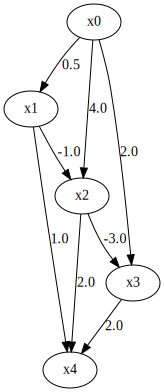

In [28]:
B = model.adjacency_matrix_.copy()
B[2, 0], B[2, 1] = get_reg_coef(X, [0, 1], 2)
B[3, 0], B[3, 1], _ = get_reg_coef(X, [0, 1, 2], 3)
B[4, 0], B[4, 1], _, _ = get_reg_coef(X, [0, 1, 2, 3], 4)
print(B)
make_graph(B, 0.1) # To align the display, the causal direction of small coefficients is excluded.